<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/kandinsky_in_colab_Datagenerator_from_Frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Files

In [2]:
!rm -r sample_data 
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg

--2019-06-02 13:53:55--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-06-02 13:53:55--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-06-02 13:53:56 (45.3 MB/s) - ‘lib.py’ saved [5214/5214]

--2019-06-02 13:53:58--  https://github.

In [3]:
from IPython.display import display, SVG
from functools import reduce
from random import seed, randint
from numpy import array, argmax
from google.colab import widgets
import google.colab.widgets as colab_widgets
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import PIL
import json
import lib
import os 
import pickle # people say import sPickle as pickle is faster

Using TensorFlow backend.


# Intro



## Encoding
X.shape = (samples, 224, 224, 3)

Y.shape = (samples, ?)

for y we can combine multible properies of a sample. 
the output shape is defined by their amount and encodings.


In [4]:
#@title Common Stuff { vertical-output: true } 
image_shape  = (224, 224)
input_shape  = (*image_shape, 3)
output_shape = (6)

print('input_shape', input_shape, 'output_shape', output_shape)

input_shape (224, 224, 3) output_shape 6


In [0]:
max_count       = output_shape
fig_id_format   = '%s/fig%06d'
fig_path_format = './figures/%s.pkl'
png_path_format = './images/%s.png'

os.makedirs('./figures/', exist_ok=True)
os.makedirs('./images/', exist_ok=True)

def save_figure(fid, fig):    
    os.makedirs('./figures/%s'%fid.split('/')[0], exist_ok=True)
    #print("create ir", path)
    with open(fig_path_format%fid, 'wb+') as dbfile:
        pickle.dump(fig, dbfile)               

def load_figure(fid):
    with open(fig_path_format%fid, 'rb') as dbfile:
        return pickle.load(dbfile)

def load_pil(fid):
    return PIL.Image.open(png_path_format%fid).resize(image_shape, PIL.Image.LANCZOS)    

def save_pil(fid, pil):
    os.makedirs('./images/%s'%fid.split('/')[0], exist_ok=True)
    pil.save(png_path_format%(fid))

def load_image(path): # used to predict image which are not in sets (like parrot)
    return PIL.Image.open(path).resize(image_shape, PIL.Image.LANCZOS)

to_onehot    = lambda val, max_int: [1 if val == i else 0 for i in range(max_int)]
count_color  = lambda f, c: reduce(lambda a, e: a + (1 if e.color==c else 0), f, 0)
count_shape  = lambda f, c: reduce(lambda a, e: a + (1 if e.shape==c else 0), f, 0)
count_size   = lambda f, c: reduce(lambda a, e: a + (1 if e.size > c[0] and e.size <= c[1] else 0), f, 0)
to_line_list = lambda dic:"\n\t".join("{:}: {},".format(k, v) for k, v in dic.items())

# Sample *s*

In [0]:
default_figure_config = dict(   
    render_size = image_shape,
    obj_count = (2, 15),     
    obj_size = (.1, .5),
    colors = ['red','yellow', 'blue'], #['red','green', 'blue', 'yellow', 'orange'],
    shapes = ['circle']
)

class Sample:  
    def __init__(self, id, fig_cfg=None):
        #print('touching sample %s/%d'%(set_path, fid))
        
        self.ID = id        
        self.f_config = fig_cfg        
        self.f, pil = self.loadOrGenerate()
            
        self.x = {            
            'fig': self.f,
            'pil': pil,
            'arr': array(pil)/255,
            #'url': pil.save(path)
        }
        self.counts = {            
            '|*|': len(self.f),
            '|r|': count_color(self.f ,'red'),
            '|y|': count_color(self.f ,'yellow'),
            '|b|': count_color(self.f ,'blue'),
            '|◯|': count_shape(self.f ,'circle'),
            '|□|': count_shape(self.f ,'rectangle'),
            '|△|': count_shape(self.f ,'trinangle'),
            '|S|': count_size(self.f , (.1, .2)),
            '|M|': count_size(self.f , (.2, .4)),
            '|L|': count_size(self.f , (.4, .5)),
        }                
        self.encoded = {
            #'encpos':   to_onehot(self.f_config.pos, 3),            
            #'enc|*|':   to_onehot(self.counts['|*|'], max_count),            
            #'enc|yL△|': to_onehot(count large yellow triangles),
            #'enc|yS△|': to_onehot(count ),
            #'enc|y△|': to_onehot(count ),
            'enc|r|':    to_onehot(self.counts['|r|'], max_count),            
            #'enc|y△ left|': to_onehot(count ),
            #'enc|y△ top|': to_onehot(count ),            
            #'enc|y△ ontop r△|': to_onehot(count ),
            #'cap': []
        }        
    
    def loadOrGenerate(self):
        if os.path.isfile(fig_path_format%self.ID):
            self.f = load_figure(self.ID)                                       # schnell
        else:
            self.f = lib.RandomFigure(**self.f_config)
            save_figure(self.ID, self.f)                                        # nicht so schnell
            
        if os.path.isfile(png_path_format%self.ID):
            pil = load_pil(self.ID)                                             # ok vermutlich
        else:
            pil = lib.kandinskyFigureAsImage(self.f, width=image_shape[0])      # ok
            save_pil(self.ID, pil)
        
        return self.f, pil
    
    def __str__(self):        
        return "%s"%self.ID
        
    def compileX(self):      
        return self.x['arr']    
    
    def compileY(self):
        #return [ *self.encoded['enc|*|'], *self.encoded['enc|r|'] ]
        return [ *self.encoded['enc|r|'] ], '%d red circles'%self.counts['|r|']
                
    def compilePandaColumns(self):
        return { 
            **{
                'ID': self.ID, 
                'file': "%s.png"%self.ID.split('/')[1],
                #'Xshape': self.x['arr'].shape, 
                'Yreadable': self.compileY()[1]
            },
            **self.counts,
            **self.encoded
        }
    
    def plot(self, verbose=0, TitlePrefix=None):                
        fig_str =  '\n'.join([str(f) for f in self.f])
        y_str =    '\n'.join([str(y) for y in self.compileY()])
        x_dim =    '%s [%.0f…%.0f]'%(self.x['arr'].shape, np.min(self.x['arr']), np.max(self.x['arr']))
        counts =   '\n'.join(['%s= %s'%(k, v) for k, v in self.counts.items()])
        encoded =  '\n'.join(['%s= %s'%(k, v) for k, v in self.encoded.items()])        
        
        #plt.xlabel('\n'.join([x_dim, y_str, fig_str, counts, encoded]))
        if verbose == 0: plt.xlabel('X= %s\nY= %s'%(x_dim, y_str))        
        if verbose == 1: plt.xlabel('X= %s\nY= %s\n\n%s'%(x_dim, y_str, counts))        
        if verbose == 2: plt.xlabel('X= %s\nY= %s\n\n%s\n\n%s \n\n%s'%(x_dim, y_str, fig_str, counts, encoded))        
        plt.imshow(self.x['pil'])        
        plt.title(self)        
        plt.show()

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

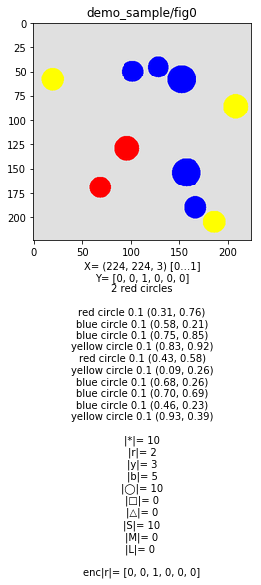

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

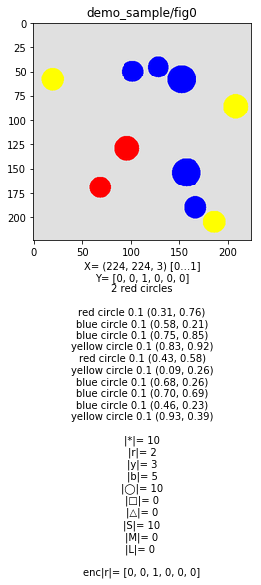

<IPython.core.display.Javascript object>

In [7]:
#@title Create a Sample { vertical-output: true, output-height: 500 }

print("Figure Configuration= {\n\t%s\n}"%to_line_list(default_figure_config))

grid = widgets.Grid(1, 2)
with grid.output_to(0, 0):
    example = Sample('demo_sample/fig0', default_figure_config)
    example.plot(verbose=2)        

with grid.output_to(0, 1):
    example_loaded = Sample('demo_sample/fig0', default_figure_config)
    example_loaded.plot(verbose=2)    

# plot demo
#https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/
#notebooks/04.08-Multiple-Subplots.ipynb




 # Now a Batch of Samples


shape= (100, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 8

Class names= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles' '6 red circles' '7 red circles']

sklearn classweights=  [1.5625     0.52083333 0.625      0.78125    1.04166667 1.13636364
 2.08333333 4.16666667]

Panda info=
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
ID           100 non-null object
Yreadable    100 non-null object
enc|r|       100 non-null object
file         100 non-null object
|*|          100 non-null int64
|L|          100 non-null int64
|M|          100 non-null int64
|S|          100 non-null int64
|b|          100 non-null int64
|r|          100 non-null int64
|y|          100 non-null int64
|□|          100 non-null int64
|△|          100 non-null int64
|◯|          100 non-n

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

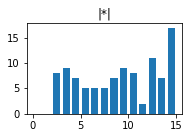

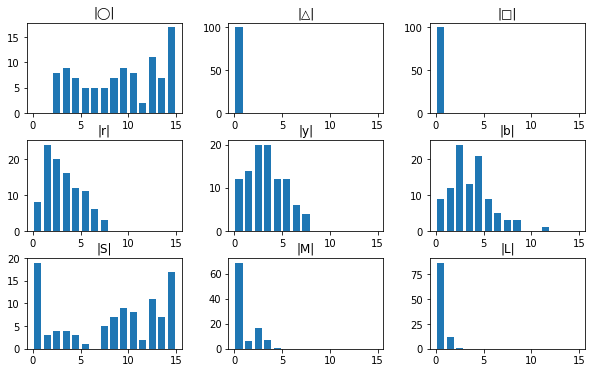

<IPython.core.display.Javascript object>

In [8]:
#@title First Batch { vertical-output: true }
first_batch_size = 100 #@param {type:"slider", min:1, max:200, step:5}

def generate_batch(set_path, figure_config, batch_size, batch_index):  
    #print('generating', n_samples)
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        ID = fig_id_format%(set_path, batch_index * batch_size + i)
        n = Sample(ID, figure_config)
        X.append(n.compileX())
        y.append(n.compileY())
        c.append(n.compilePandaColumns())

    return array(X), array(y), pd.DataFrame(data=c)
    
def sklearn_class_weight_from_vector(v):
    classes = f['Yreadable']
    return compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)

def sklearn_class_weight_from_frame(f):
    return sklearn_class_weight_from_vector(f['Yreadable'])
    
def display_batch_stats(f, fig_cfg):    
    max_objects = fig_cfg['obj_count'][1]
    args = { 
        'rwidth': .75,
        'range': (0, max_objects),
        'bins': max_objects,
        'grid': False,
        'align': 'mid' #'left', 'mid', 'right'
    }
    fig = plt.figure(figsize=(10, 6))# tight_layout=True)    
    f.hist(column='|*|', **args, ax=fig.add_subplot(331))    
    fig = plt.figure(figsize=(10, 6))
    f.hist(column='|◯|', **args, ax=fig.add_subplot(331)) # Divide into a 1x4 grid, give first section    
    f.hist(column='|△|', **args, ax=fig.add_subplot(332))
    f.hist(column='|□|', **args, ax=fig.add_subplot(333))    
    f.hist(column='|r|', **args, ax=fig.add_subplot(334))
    f.hist(column='|y|', **args, ax=fig.add_subplot(335))
    f.hist(column='|b|', **args, ax=fig.add_subplot(336))
    f.hist(column='|S|', **args, ax=fig.add_subplot(337))
    f.hist(column='|M|', **args, ax=fig.add_subplot(338))
    f.hist(column='|L|', **args, ax=fig.add_subplot(339))
    
def display_batch_meta(batch_panda, fig_cfg):
    print("\nshape=", batch_panda.shape)
    t = colab_widgets.TabBar(["Info", "Plots"])    
    with t.output_to(0):
        print("Figure Configuration= {\n\t%s\n}"%to_line_list(fig_cfg))
        print("\nMax |r| in training set=", np.max(batch_panda['|r|'] + 1))
        print("\nClass names=", np.unique(batch_panda['Yreadable'])) 
        print("\nsklearn classweights= ", sklearn_class_weight_from_frame(batch_panda))
        print("\nPanda info=")
        batch_panda.info()
    
    with t.output_to(1):
        display_batch_stats(batch_panda, fig_cfg)    
        
A, b, f = generate_batch('view_batch', default_figure_config, first_batch_size, 0)    

display_batch_meta(f, default_figure_config)

(100, 224, 224, 3) (100, 2) (100, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ID,Yreadable,enc|r|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
0,view_batch/fig000000,3 red circles,"[0, 0, 0, 1, 0, 0]",fig000000.png,10,0,0,10,3,3,4,0,0,10
1,view_batch/fig000001,5 red circles,"[0, 0, 0, 0, 0, 1]",fig000001.png,15,0,0,15,8,5,2,0,0,15
2,view_batch/fig000002,1 red circles,"[0, 1, 0, 0, 0, 0]",fig000002.png,4,1,2,1,2,1,1,0,0,4
3,view_batch/fig000003,1 red circles,"[0, 1, 0, 0, 0, 0]",fig000003.png,3,0,3,0,2,1,0,0,0,3
4,view_batch/fig000004,5 red circles,"[0, 0, 0, 0, 0, 1]",fig000004.png,12,0,0,12,4,5,3,0,0,12
5,view_batch/fig000005,3 red circles,"[0, 0, 0, 1, 0, 0]",fig000005.png,15,0,0,15,11,3,1,0,0,15
6,view_batch/fig000006,2 red circles,"[0, 0, 1, 0, 0, 0]",fig000006.png,6,0,3,3,1,2,3,0,0,6
7,view_batch/fig000007,4 red circles,"[0, 0, 0, 0, 1, 0]",fig000007.png,15,0,0,15,4,4,7,0,0,15
8,view_batch/fig000008,1 red circles,"[0, 1, 0, 0, 0, 0]",fig000008.png,2,1,1,0,1,1,0,0,0,2
9,view_batch/fig000009,4 red circles,"[0, 0, 0, 0, 1, 0]",fig000009.png,8,0,0,8,2,4,2,0,0,8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 1, 0, 0]), '3 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 0, 1]), '5 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 1, 0, 0, 0, 0]), '1 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 1, 0, 0, 0, 0]), '1 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 0, 1]), '5 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 1, 0, 0]), '3 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 1, 0, 0, 0]), '2 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 1, 0]), '4 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 1, 0, 0, 0, 0]), '1 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 1, 0]), '4 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

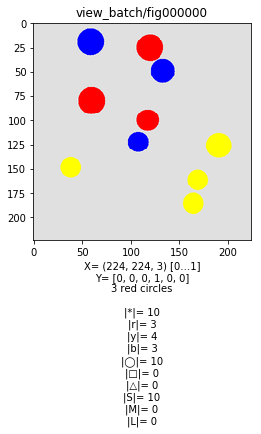

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

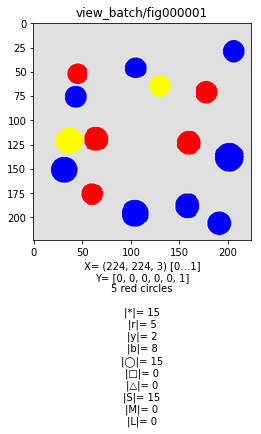

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

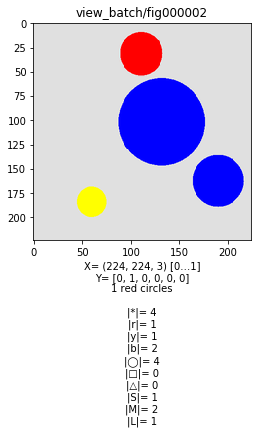

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

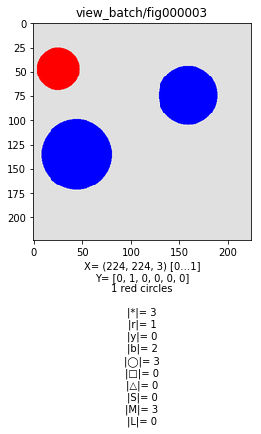

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

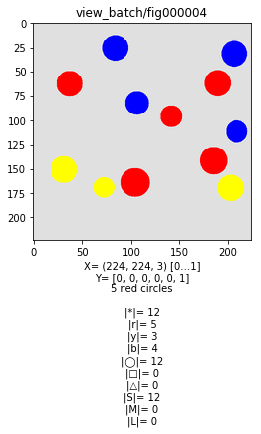

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

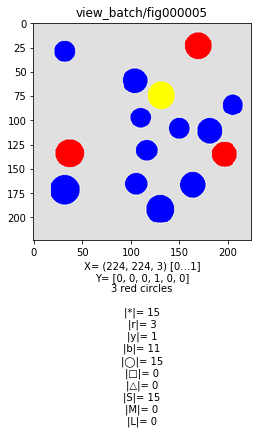

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

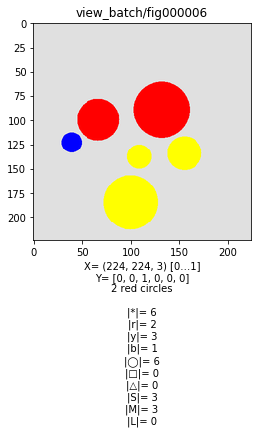

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

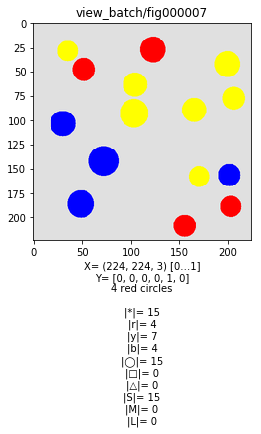

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

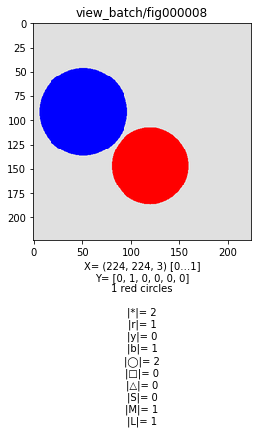

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

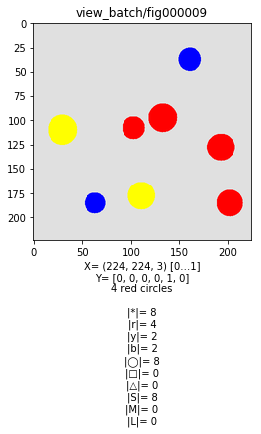

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#@title Show Sample Batch ((A, b), f) { run: "auto", vertical-output: true }
batch_view_len = 10 #@param {type:"slider", min:1, max:30, step:1}
    
def display_batch_content(batch, f_batch, batch_view_len):    
    print(batch[0].shape, batch[1].shape, f.shape)
    t = colab_widgets.TabBar(["Panda", "Network encoding", "Sample View"])
    
    visible_samples = min(batch_view_len, len(f_batch))
    with t.output_to(0):
        display(f_batch[0:visible_samples])
    
    with t.output_to(1):
        grid = colab_widgets.Grid(visible_samples, 2)
        for s in range(visible_samples):
            with grid.output_to(s, 0):
                display(batch[0][s])        
            with grid.output_to(s, 1):
                display(batch[1][s])
    
    with t.output_to(2):
        grid = colab_widgets.Grid(1, visible_samples)
        for s in range(visible_samples):            
            with grid.output_to(0, s):
                ID = f_batch['ID'][s]
                Sample(ID, default_figure_config).plot(verbose=1)
            
display_batch_content((A, b), f, batch_view_len)

# Datagenerator.*renderFrame* returns a panda frame with sample meta info

And cerates the images and figure files

In [0]:
# https://github.com/keras-team/keras/issues/12586
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=None, out_dim=None, figure_parameters=None):        
        self.set_path = set_path
        self.figure_parameters = figure_parameters
        self.n_samples = samples
        
        self.batch_size = batch_size
        
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx): 
        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
        #ids = ["%d"%k for k in indexes]        
        X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)                
        return X, y
    
    def renderFrame(self):
        self.panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)        
            self.panda = self.panda.append(f)    
        print(len(self), self.set_path, "Batches touched (%s)"%self.set_path)
        #print(panda['file'])
        
        #self.classes =
        #self.class_weight_sklearn =
        
        
        return self, self.panda

571 train Batches touched (train)
47 valid Batches touched (valid)

shape= (11991, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 12

Class names= ['0 red circles' '1 red circles' '10 red circles' '11 red circles'
 '2 red circles' '3 red circles' '4 red circles' '5 red circles'
 '6 red circles' '7 red circles' '8 red circles' '9 red circles']

sklearn classweights=  [1.5625     0.52083333 0.625      0.78125    1.04166667 1.13636364
 2.08333333 4.16666667]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 20
Data columns (total 14 columns):
ID           11991 non-null object
Yreadable    11991 non-null object
enc|r|       11991 non-null object
file         11991 non-null object
|*|          11991 non-null int64
|L|          11991 non-null int64
|M|          11991 non-null int64
|S|          11991 non-null int64
|b|          11991 non-null int64
|r|          11991 non-null int64
|y|          11991 non-null 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

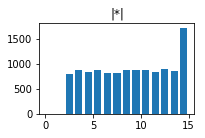

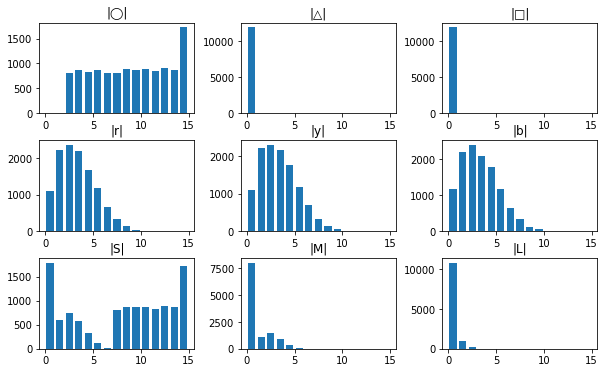

<IPython.core.display.Javascript object>

CPU times: user 4min 9s, sys: 4.9 s, total: 4min 14s
Wall time: 4min 14s


In [11]:
#@title Create Training/Validation Set. Show Training Set (f, fig_cfg) { vertical-output: true }
%%time

batch_size      = 21 #@param {type:"slider", min:1, max:200, step:5}
training_size   = 12000 #@param {type:"slider", min:100, max:20000, step:100}
validation_size = 1000 #@param {type:"slider", min:100, max:1500, step:10}

params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

training_generator, training_panda = DataGenerator(
    set_path="train", samples=training_size, **params).renderFrame()

validation_generator, validation_panda = DataGenerator(
    set_path="valid", samples=validation_size, **params).renderFrame()

class_weight_raw = sklearn_class_weight_from_frame(training_panda)


display_batch_meta(training_panda, params['figure_parameters'])


Training batches=  11991
Training Panda=  11991
False
batch_size=  21
slice= 1008 1029
(21, 224, 224, 3) (21, 2) (100, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ID,Yreadable,enc|r|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
0,train/fig001008,3 red circles,"[0, 0, 0, 1, 0, 0]",fig001008.png,5,0,2,3,0,3,2,0,0,5
1,train/fig001009,1 red circles,"[0, 1, 0, 0, 0, 0]",fig001009.png,2,1,1,0,0,1,1,0,0,2
2,train/fig001010,7 red circles,"[0, 0, 0, 0, 0, 0]",fig001010.png,12,0,0,12,3,7,2,0,0,12
3,train/fig001011,3 red circles,"[0, 0, 0, 1, 0, 0]",fig001011.png,12,0,0,12,6,3,3,0,0,12
4,train/fig001012,3 red circles,"[0, 0, 0, 1, 0, 0]",fig001012.png,6,0,3,3,0,3,3,0,0,6
5,train/fig001013,4 red circles,"[0, 0, 0, 0, 1, 0]",fig001013.png,6,0,3,3,2,4,0,0,0,6
6,train/fig001014,2 red circles,"[0, 0, 1, 0, 0, 0]",fig001014.png,5,0,3,2,1,2,2,0,0,5
7,train/fig001015,4 red circles,"[0, 0, 0, 0, 1, 0]",fig001015.png,12,0,0,12,4,4,4,0,0,12
8,train/fig001016,0 red circles,"[1, 0, 0, 0, 0, 0]",fig001016.png,2,1,1,0,0,0,2,0,0,2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 1, 0, 0]), '3 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 1, 0, 0, 0, 0]), '1 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 0, 0]), '7 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 1, 0, 0]), '3 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 1, 0, 0]), '3 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 1, 0]), '4 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 1, 0, 0, 0]), '2 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([0, 0, 0, 0, 1, 0]), '4 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([list([1, 0, 0, 0, 0, 0]), '0 red circles'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

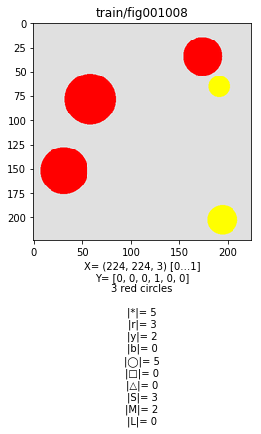

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

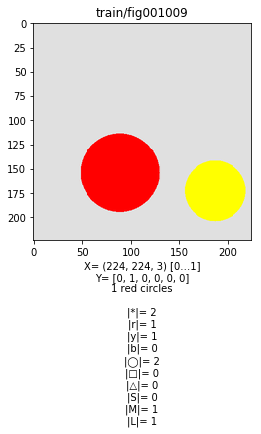

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

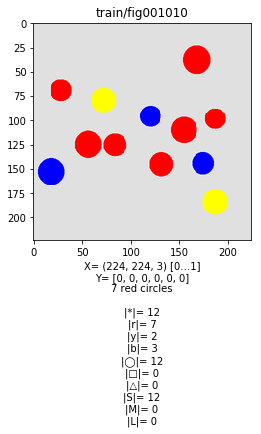

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

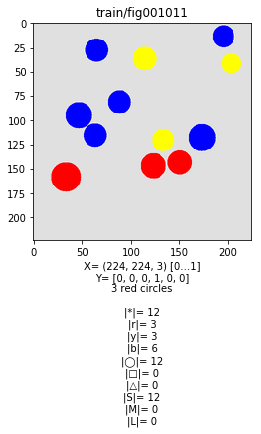

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

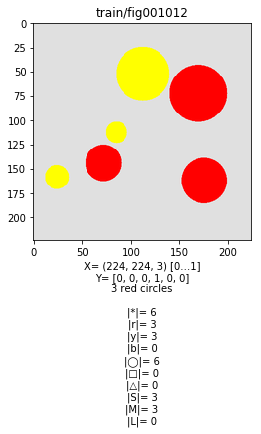

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

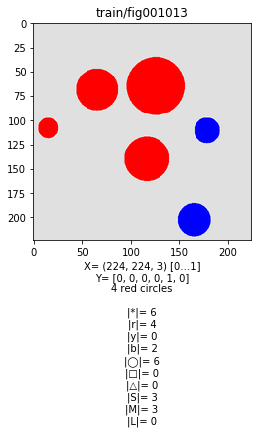

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

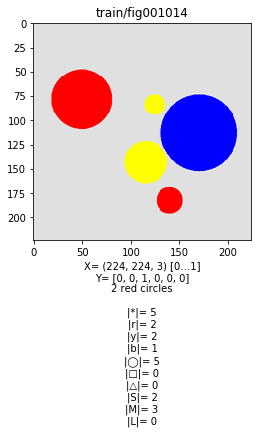

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

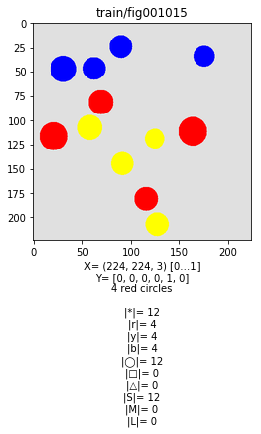

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

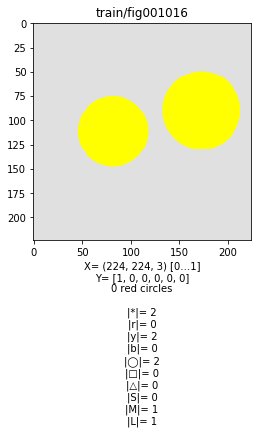

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
#@title Review Training Generator Content (X, Y, f) (Sample View) { run: "auto", vertical-output: true }

batch_to_view  = 48 #@param {type:"slider", min:0, max:50, step:3}
batch_view_len = 9 #@param {type:"slider", min:1, max:20, step:1}

print("Training batches= ", len(training_generator)*training_generator.batch_size)
print("Training Panda= ", len(training_panda))
print(len(training_generator) == len(training_panda)*training_generator.batch_size)

print("batch_size= ", batch_size)
print("slice=", batch_to_view*batch_size, (batch_to_view+1)*batch_size)

display_batch_content(
    training_generator[batch_to_view], 
    training_panda[batch_to_view*batch_size:(batch_to_view+1)*batch_size], 
    batch_view_len
)

In [13]:
#@title Second time sould be Faster. (images are already cached) { vertical-output: true }
%%time

training_generator,   _ = DataGenerator(set_path="train", samples=training_size,   **params).renderFrame()
validation_generator, _ = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()

571 train Batches touched (train)
47 valid Batches touched (valid)
CPU times: user 31.2 s, sys: 1.42 s, total: 32.6 s
Wall time: 32.7 s


# Do we really want to remove samples here? Dataset Filter (panda only)


shape= (10792, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 6

Class names= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']

sklearn classweights=  [1.5625     0.52083333 0.625      0.78125    1.04166667 1.13636364
 2.08333333 4.16666667]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10792 entries, 0 to 20
Data columns (total 14 columns):
ID           10792 non-null object
Yreadable    10792 non-null object
enc|r|       10792 non-null object
file         10792 non-null object
|*|          10792 non-null int64
|L|          10792 non-null int64
|M|          10792 non-null int64
|S|          10792 non-null int64
|b|          10792 non-null int64
|r|          10792 non-null int64
|y|          10792 non-null int64
|□|          10792 non-null int64
|△|          10792 non-null int64
|◯|          10792 non-nul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

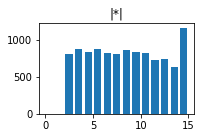

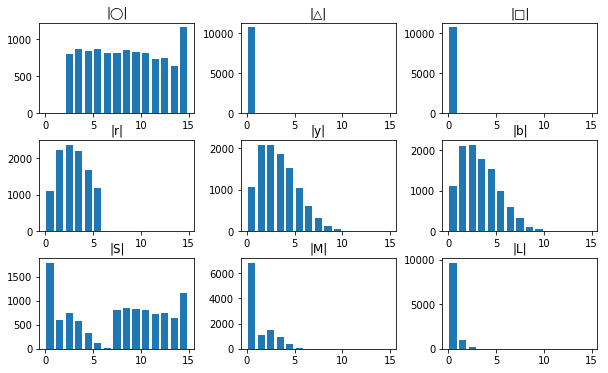

<IPython.core.display.Javascript object>

In [14]:
#@title Select Classes (training_panda → training_panda_filterd) { vertical-output: true }

#training_generator.panda = training_generator.panda.astype({"Yreadable": str})
#training_generator.panda = training_generator.panda.infer_objects()

def filter_panda(panda):
    return panda.loc[panda['Yreadable'].isin([# ['%d red circles'%i for i in range(0, 5+1)]
        '0 red circles', 
        '1 red circles', 
        '2 red circles', 
        '3 red circles', 
        '4 red circles',
        '5 red circles',
    ])]

#def filter_panda(panda): 
    #return panda

training_panda_filterd = filter_panda(training_panda)
validation_panda_filterd = filter_panda(validation_panda)

class_weight_from_frame = sklearn_class_weight_from_frame(training_panda_filterd)

display_batch_meta(training_panda_filterd, params['figure_parameters'])
#display_batch_meta(validation_panda_filterd, params['figure_parameters'])

# Flow from Panda Frame Generator

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

argumented_training_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 180,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [1, 1.5],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)
argumented_validation_generator = ImageDataGenerator(rescale=1./255)

In [16]:
#@title Data Augmentation and Y Declaration { vertical-output: true }

def convert_for_keras(panda):
    select_keras = panda #select3.sort_values(by=['Yreadable'])
    select_keras.loc[:,'Yreadable'] = select_keras.loc[:,'Yreadable'].astype('category')
    select_keras.loc[:,'file']   = select_keras.loc[:,'file'].astype(str)
    return select_keras

    print("select_keras shape=", select_keras.shape)
    print("\nselect_keras dtypes=\n", select_keras.dtypes)
    print("\nclasses in Yreadable=", np.unique(select_keras['Yreadable']))

from_frame_args = dict(
    x_col = 'file',
    y_col = 'Yreadable', #'enc|r|', #'|r|', # ja wirklich nicht Y, weil ImageDataGenerator im categorical 
    # mode automatisch zu onehot convertiert (wenn man ihm auch die classes gibt?)    
    # 'categorical' for string?
    # 'other' for  if Y is int
    class_mode = 'categorical',    
    batch_size = batch_size,
    target_size = image_shape,
    shuffle = False
)
    
print("\n")
training_generator_from_table = argumented_training_generator.flow_from_dataframe(
    dataframe = convert_for_keras(training_panda_filterd),
    directory = './images/train/',
    **from_frame_args
)

validation_generator_from_table = argumented_validation_generator.flow_from_dataframe(
    dataframe = convert_for_keras(validation_panda_filterd),
    directory = './images/valid/',
    **from_frame_args
)

training_generator_from_table.batch_size, len(training_generator_from_table)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Found 10792 images belonging to 6 classes.
Found 892 images belonging to 6 classes.


(21, 514)

# Flow from Directory Generator

In [0]:
!mkdir images_categorical
!mkdir images_categorical/train
!mkdir images_categorical/test

#!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/kandinsky_color_large.tar.gz -vP images_categorical      
#!tar -xzf  images_categorical/kandinsky_color_large.tar.gz -C images_categorical/train

#!mv images_categorical/train/A/test images_categorical/test/A
#!mv images_categorical/train/B/test images_categorical/test/B
#!mv images_categorical/train/C/test images_categorical/test/C
#!mv images_categorical/train/D/test images_categorical/test/D
#!mv images_categorical/train/E/test images_categorical/test/E
#!mv images_categorical/train/F/test images_categorical/test/F

In [0]:
# OR: foreach panda row
#          move file to targetpath/Yast/i_nr.png

In [19]:
training_generator_from_directory = argumented_training_generator.flow_from_directory(
    directory = 'images_categorical/train',
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

validation_generator_from_directory = argumented_validation_generator.flow_from_directory(
    directory = 'images_categorical/test',
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

class_weight_from_directory = sklearn_class_weight_from_vector(training_generator_from_directory.classes)
print(np.unique(training_generator_from_directory.classes))
print(class_weight_from_directory)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
[]
[1.5625     0.52083333 0.625      0.78125    1.04166667 1.13636364
 2.08333333 4.16666667]


# Data ready - Load  VGG16

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 47s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

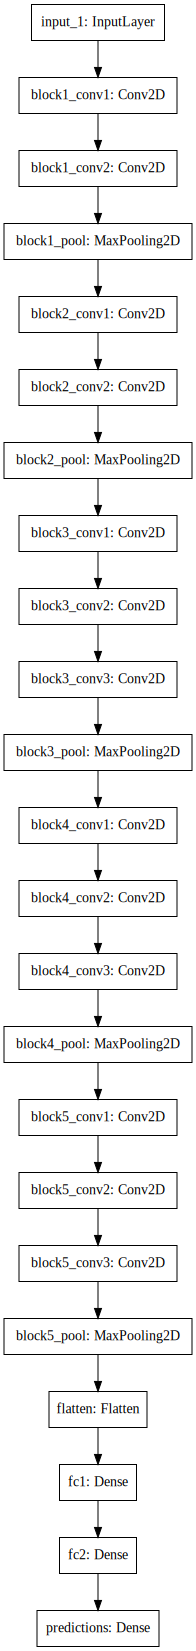

In [20]:
#@title Download VGG16 { vertical-output: true, output-height: 400 }

vgg16_init_weights = 'imagenet' #@param ["'imagenet'", "None"] {type:"raw"}

from tensorflow.python.keras.applications import VGG16

vgg16model = VGG16(include_top=True, weights=vgg16_init_weights)
vgg16model.summary()
SVG(keras.utils.vis_utils.model_to_dot(vgg16model).create(prog='dot', format='svg'))

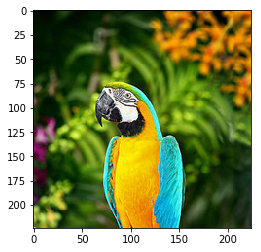

40960/35363 [==================================] - 0s 5us/step
79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [21]:
#@title Make a prediction with vgg16 imagenet weights{ vertical-output: true }

from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_array):
    plt.imshow(image_array)
    plt.show()
    
    img_array = np.expand_dims(image_array, axis=0)   
    
    pred = vgg16model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))  
        
predict(load_image('parrot_cropped1.jpg'))
#predict(image_path=image_paths_train[0])

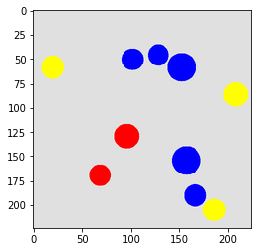

 5.42% : envelope
 4.17% : mosquito_net
 3.27% : shower_curtain
 3.06% : toilet_tissue
 2.27% : toilet_seat


In [22]:
#@title predict a Kandinsky Figure with VGG16 imagenet weights { vertical-output: true }
predict(example.x['arr'])

# Creating a Model: VGG16[0:block5_pool] + 2 new Dense Layers

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 40,411,974
Non-trainable params: 0
_________________________________________________________________


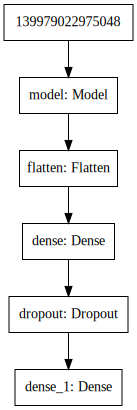

In [23]:
#@title Creating a new Model { vertical-output: true, output-height: 300 }
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam, RMSprop

conv_model = Model(inputs=vgg16model.input, outputs=vgg16model.get_layer('block5_pool').output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(output_shape, activation='softmax'))

new_model.summary()
SVG(keras.utils.vis_utils.model_to_dot(new_model).create(prog='dot', format='svg'))

In [24]:
#@title Compile after trainable Layers are set { vertical-output: true }
optimizer     = "adam"                     #@param ["adam" ,"other"]
learning_rate = 0.01                       #@param {type:"slider", min:1e-7, max:0.01, step:1e-3}
loss          = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
main_metric   = "categorical_accuracy"     #@param ["accuracy", "categorical_accuracy"]
train_vgg16   = True #@param {type:"boolean"}

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')

conv_model.trainable = train_vgg16
for layer in conv_model.layers: layer.trainable = train_vgg16
    
new_model.compile(
    optimizer = Adam(lr=1e-5), 
    loss = loss, 
    metrics = [main_metric]
)

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')


True True True True True True True True True True True True True True True True True True True 

True True True True True True True True True True True True True True True True True True True 



# Training

In [0]:
#used_training_generator = training_generator                   # from DataGenerator implementation (files already created, may loads figures and images, but X is transfered in memory)
used_training_generator = training_generator_from_table         # flow_from_dataframe (from panda frame)
#used_training_generator = training_generator_from_directory    # flow_from_directory (hvass style)            geht mit tar.gz download oder hier figures generieren

used_validation_generator = validation_generator_from_table
#used_validation__generator = validation__generator_from_table
#used_validation_generator = validation_generator_from_directory

#class_weight = class_weight_raw
class_weight = class_weight_from_frame
#class_weight = class_weight_from_directory

In [0]:
#show_batches(validation_generator)
#show_batches(validation_generator_from_table)
#show_batches(validation_generator_from_directory)

In [1]:
#@title View Generators. only with (X, Y) (imshowXView) { run: "auto", vertical-output: true }
#https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw

def show_batches(name, generator):    
    print("\n%s: len=%d, batch_size=%d"%(name, len(generator), generator.batch_size))
    #generator.reset()?
    
    batch_to_view = 0 #@param {type:"slider", min:0, max:100, step:3}
    batch_view_len = 10 #@param {type:"slider", min:1, max:20, step:1}
    
    X = generator[batch_to_view][0]
    Y = generator[batch_to_view][1]
    
    image_count = min(batch_view_len, generator.batch_size)
    
    grid = widgets.Grid(1, batch_view_len)
    for i in range(image_count):
        with grid.output_to(0, i):        
            plt.title('Batch %d - Item %d\nY= %s\nTodo:Y decoded'%(batch_to_view, i, Y[i]))
            # assert X = Sample(id=batch*batch_size+i).X
            plt.imshow(X[i])
            plt.show()

show_batches('Raw', training_generator)
show_batches('Table', training_generator_from_table)
#show_batches('Directory', training_generator_from_directory)


NameError: ignored

batch_size= 21 batch_count= 515 samples*= 10815 
epochs= 2 steps_per_epoch= 112 samples_per_step*= 96


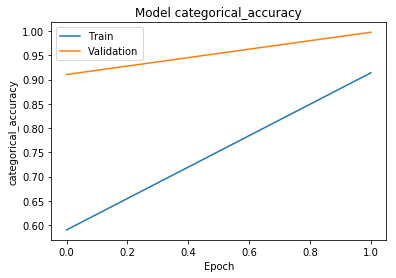

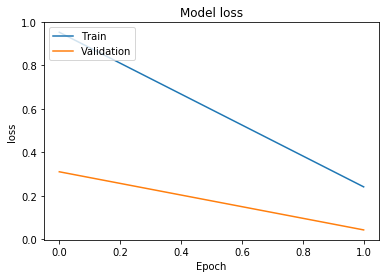

categorical_accuracy = 0.9141615
val_categorical_accuracy = 0.99776536
CPU times: user 401 ms, sys: 239 ms, total: 640 ms
Wall time: 354 ms


In [0]:
#@title Training { vertical-output: true }
%%time

steps_per_epoch    = 112 #@param {type:"slider", min:10, max:500, step:1}
epochs             = 2 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 30 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'dense' #@param ["'all'", "'dense'", "'vgg16[5,6]'"] {type:"raw"}
use_multprocessing = False #@param {type:"boolean"}
workers            = 8 #@param {type:"slider", min:1, max:64, step:1}
verbose            = 1 #@param {type:"slider", min:0, max:5, step:1}

print(
    "batch_size=", used_training_generator.batch_size, 
    "batch_count=", len(used_training_generator), 
    "samples*=", used_training_generator.batch_size * len(used_training_generator), 
    "\nepochs=", epochs, 
    "steps_per_epoch=", steps_per_epoch, 
    "samples_per_step*=", int(used_training_generator.batch_size * len(used_training_generator) 
                              / steps_per_epoch)
)

fit_result1 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

def plot_metric(history, m):        
        plt.plot(history[m])
        plt.plot(history['val_%s'%m])
        plt.title('Model %s'%m)
        plt.ylabel(m)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
def plot_history(history):    
    plot_metric(history, main_metric)
    plot_metric(history, 'loss')
    print(main_metric,          "=", history[main_metric][-1])
    print("val_%s"%main_metric, "=", history["val_%s"%main_metric][-1])

#history_merge =  merge_history(history_merge, fit_result2.history) if history_merge else fit_result1.history
history_merge = fit_result1.history
plot_history(history_merge)

515/515 [==============================] - 194s 376ms/step - loss: 0.1179 - categorical_accuracy: 0.9681 - val_loss: 0.0305 - val_categorical_accuracy: 0.9933
categorical_accuracy = 0.96808803


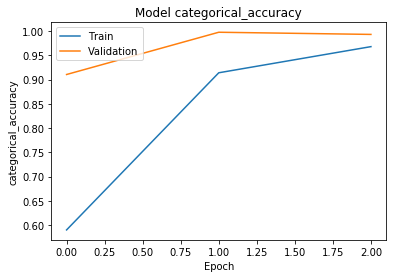

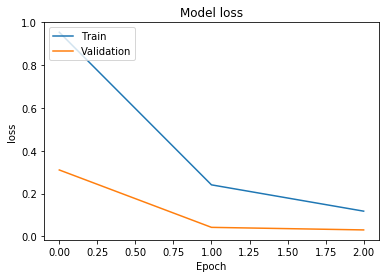

categorical_accuracy = 0.96808803
val_categorical_accuracy = 0.9932961
CPU times: user 4min 20s, sys: 55 s, total: 5min 15s
Wall time: 3min 14s


In [0]:
#@title Training { vertical-output: true }
%%time

epochs             = 1 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 2 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'all' #@param ["'all'", "'vgg16'", "'vgg16[5,6]'"] {type:"raw"}

fit_result2 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

print(main_metric, "=", fit_result2.history[main_metric][-1])

def merge_history(h1, h2):
    assert(h1.keys() == h2.keys())
    history_merge_values = list(map(lambda ek: h1[ek] + h2[ek], h1.keys()))
    return dict(zip(h1.keys(), history_merge_values)) 
    
history_merge = merge_history(history_merge, fit_result2.history)    
plot_history(history_merge)

# Checkpoint

In [27]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = '/content/drive/My Drive/colab/kandinsky/%s'

In [29]:
!ls "drive/My Drive/colab/kandinsky" -l

total 631562
-rw------- 1 root root 485034872 May 31 18:03 my_model.h5
-rw------- 1 root root 161684152 May 31 21:01 my_model_weights.h5


In [0]:
#new_model.save(drive_path%'my_model.h5')
#new_model.save_weights(drive_path%'my_model_weights.h5')

In [0]:
#new_model_loaded = load_model(drive_path%'my_model.h5')

new_model_loaded = new_model
new_model_loaded.load_weights(drive_path%'my_model_weights.h5')

# Evaluation TODO: bug show_prediction und show_batch (jeder kann etwas)

In [37]:
#@title Data Generators for test { vertical-output: true }
%%time
batch_size      = 31 #@param {type:"slider", min:1, max:200, step:5}
test_size       = 30000 #@param {type:"slider", min:100, max:30000, step:10}

test_params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

print("Figure Configuration= {\n\t%s\n}"%to_line_list(test_params['figure_parameters']))
test_generator, test_panda = DataGenerator(set_path="test", samples=test_size, **test_params).renderFrame()

class_count_of_test_raw = np.max(test_panda['|r|'])
print("Generated class count of test set=", class_count_of_test_raw)

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}
967 test Batches touched (test)
Generated class count of test set= 12
CPU times: user 6min 14s, sys: 6.04 s, total: 6min 20s
Wall time: 6min 20s


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Found 27071 images belonging to 6 classes.

shape= (27071, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 6

Class names= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']

sklearn classweights=  [1.5625     0.52083333 0.625      0.78125    1.04166667 1.13636364
 2.08333333 4.16666667]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27071 entries, 0 to 30
Data columns (total 14 columns):
ID           27071 non-null object
Yreadable    27071 non-null category
enc|r|       27071 non-null object
file         27071 non-null object
|*|          27071 non-null int64
|L|          27071 non-null int64
|M|          27071 non-null int64
|S|          27071 non-null int64
|b|          27071 non-null int64
|r|          27071 non-null int64
|y|          27071 non-null int64
|□|          27071 non-null int64
|△|          27071 non-null int64
|◯|          27071 non-n

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

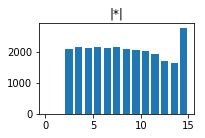

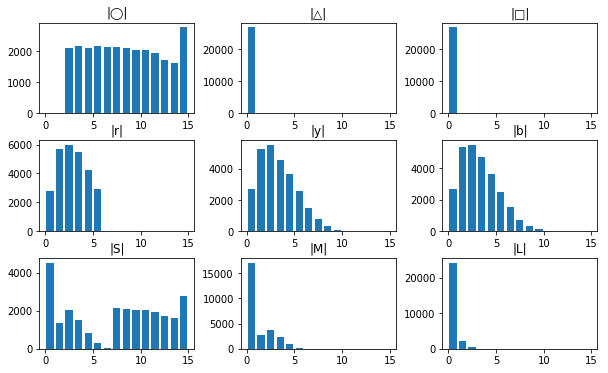

<IPython.core.display.Javascript object>

In [38]:
#@title Use same filter for test set { run: "auto", vertical-output: true }
test_panda_filterd = filter_panda(test_panda)

class_weight_test = sklearn_class_weight_from_frame(test_panda_filterd)

# ja wirklich argumented_validation_generator weil ich hier nur x laden will
test_generator_from_table = argumented_validation_generator.flow_from_dataframe(    
    dataframe = convert_for_keras(test_panda_filterd),
    directory = './images/test/',
    **from_frame_args
)

used_test_generator = test_generator_from_table
used_test_panda = test_panda_filterd

display_batch_meta(used_test_panda, test_params['figure_parameters'])

In [39]:
#@title Predict Test Set { run: "auto", vertical-output: true }
%%time 

print("Accuracy %s" % new_model.evaluate_generator(used_test_generator)[1])

# nicht erfüllt da letzter batch fehlt?
#assert(used_test_panda.shape[0] == len(used_test_generator)*used_test_generator.batch_size)
print('Test set length= ',used_test_panda.shape[0], 
      "?=", len(used_test_generator)*used_test_generator.batch_size)

y_pred = new_model.predict_generator(used_test_generator)
y_pred_nr = np.argmax(y_pred, axis=1)
used_test_panda['Ypredicted'] = ['%d red circles'%nr for nr in y_pred_nr]

print("expected\t", used_test_panda['Yreadable'].tolist())
print("predicted\t", used_test_panda['Ypredicted'].tolist())

mask = (used_test_panda['Yreadable'] != used_test_panda['Ypredicted'])
used_test_panda['mask'] = mask

print("mask\t\t", mask.tolist())
print("\nnumber of false predictions", np.sum(mask))

Accuracy 0.9940896
Test set length=  27071 ?= 27090
expected	 ['2 red circles', '1 red circles', '4 red circles', '5 red circles', '3 red circles', '2 red circles', '1 red circles', '2 red circles', '3 red circles', '3 red circles', '0 red circles', '5 red circles', '4 red circles', '1 red circles', '2 red circles', '2 red circles', '1 red circles', '2 red circles', '2 red circles', '3 red circles', '5 red circles', '1 red circles', '3 red circles', '3 red circles', '1 red circles', '1 red circles', '2 red circles', '2 red circles', '0 red circles', '5 red circles', '2 red circles', '2 red circles', '3 red circles', '5 red circles', '4 red circles', '3 red circles', '2 red circles', '0 red circles', '1 red circles', '1 red circles', '0 red circles', '2 red circles', '5 red circles', '5 red circles', '2 red circles', '1 red circles', '4 red circles', '1 red circles', '4 red circles', '2 red circles', '0 red circles', '2 red circles', '3 red circles', '3 red circles', '2 red circles', '2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Yreadable,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|,Ypredicted,mask
7,test/fig000100,4 red circles,9,0,0,9,3,4,2,0,0,9,3 red circles,True
18,test/fig000235,4 red circles,5,0,2,3,0,4,1,0,0,5,3 red circles,True
2,test/fig000281,5 red circles,12,0,0,12,3,5,4,0,0,12,4 red circles,True
13,test/fig000385,4 red circles,6,0,2,4,0,4,2,0,0,6,3 red circles,True
19,test/fig000391,4 red circles,13,0,0,13,2,4,7,0,0,13,3 red circles,True
20,test/fig000609,4 red circles,15,0,0,15,6,4,5,0,0,15,3 red circles,True
5,test/fig001183,4 red circles,14,0,0,14,5,4,5,0,0,14,3 red circles,True
27,test/fig001236,5 red circles,10,0,0,10,2,5,3,0,0,10,4 red circles,True
13,test/fig001315,5 red circles,15,0,0,15,4,5,6,0,0,15,4 red circles,True
4,test/fig001337,4 red circles,9,0,0,9,3,4,2,0,0,9,3 red circles,True



shape= (160, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 6

Class names= ['1 red circles' '2 red circles' '3 red circles' '4 red circles'
 '5 red circles']

sklearn classweights=  [1.5625     0.52083333 0.625      0.78125    1.04166667 1.13636364
 2.08333333 4.16666667]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 7 to 5
Data columns (total 14 columns):
ID            160 non-null object
Yreadable     160 non-null category
|*|           160 non-null int64
|L|           160 non-null int64
|M|           160 non-null int64
|S|           160 non-null int64
|b|           160 non-null int64
|r|           160 non-null int64
|y|           160 non-null int64
|□|           160 non-null int64
|△|           160 non-null int64
|◯|           160 non-null int64
Ypredicted    160 non-null object
mask          160 non-null bool
dtypes: bool(1), category

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

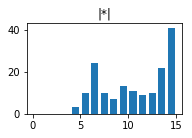

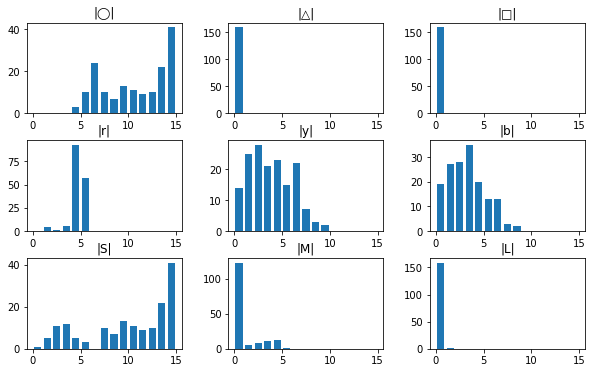

<IPython.core.display.Javascript object>

In [40]:
#@title Error Set Meta { run: "auto", vertical-output: true }

# correct: [numpy.logical_not(mask)] geht ~ auch?
error_samples_panda = used_test_panda.filter(regex='^(?!(%s))'%'file|enc*')[mask]
display(error_samples_panda)

display_batch_meta(error_samples_panda, test_params['figure_parameters'])

#print("😄:")
#display(used_test_panda.filter(regex='^(?!(%s))'%'file|enc*')[mask])

#class ErrorDataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
#    'Generates kandinsky data for Keras'
#    def __init__(self, panda, generator, batch_size=10,):        
#        self.panda = panda
#        self.generator = generator
#        self.batch_size = batch_size
#        
#    def __len__(self):        
#        return int(np.floor(len(self.panda) / self.batch_size))
#
#    def __getitem__(self, idx): 
#        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
#        #ids = ["%d"%k for k in indexes]        
#        self.generatorQ[idx]
#        X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)                
#        return X, y
    

number of false predictions 160 160
number test samples 27071


,,,,,,,,,,,
,,,,,,,,,,,


Batch 3 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

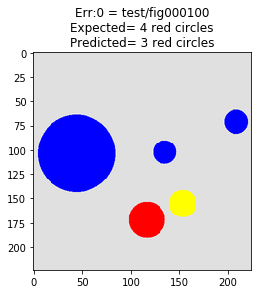

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

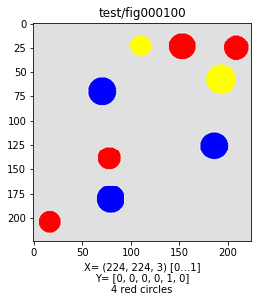

<IPython.core.display.Javascript object>

Batch 7 18


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

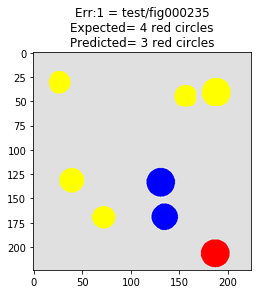

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

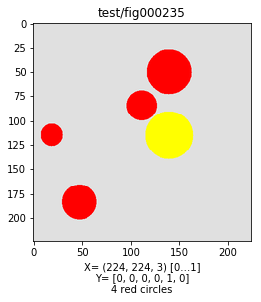

<IPython.core.display.Javascript object>

Batch 9 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

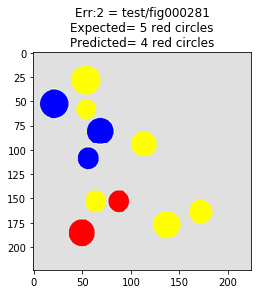

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

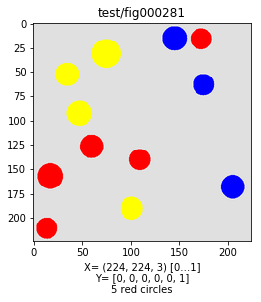

<IPython.core.display.Javascript object>

Batch 12 13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

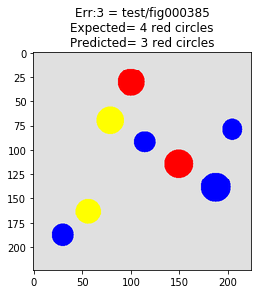

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

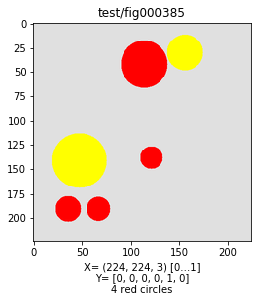

<IPython.core.display.Javascript object>

Batch 12 19


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

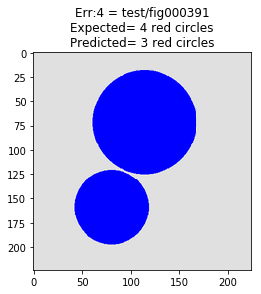

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

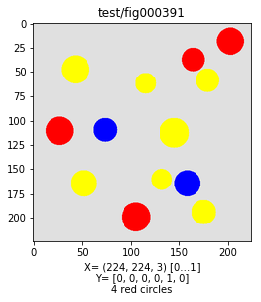

<IPython.core.display.Javascript object>

Batch 19 20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

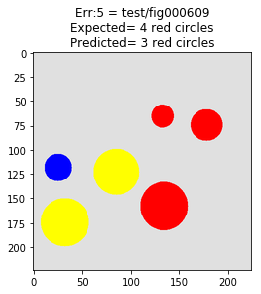

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

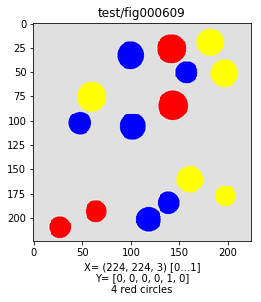

<IPython.core.display.Javascript object>

Batch 38 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

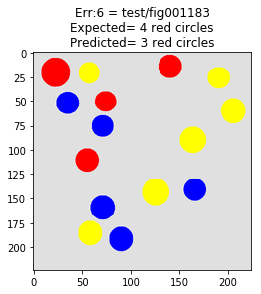

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

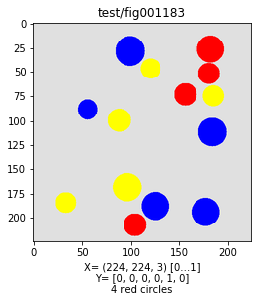

<IPython.core.display.Javascript object>

Batch 39 27


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IndexError: ignored

In [42]:
#@title Error Set Content (plt.imgshowX + SampleView) { run: "auto", vertical-output: true }
#%%time 

def plot_sample_from_arr(fid, errid, expected_str, predicted_str, x):    
    plt.title('Err:%s = %s\nExpected= %s\nPredicted= %s'%(errid, fid, expected_str, predicted_str))    
    plt.imshow(x)
    plt.show()

def show_predictions(generator, panda):
    batch_to_view = 0 #@param {type:"slider", min:0, max:100, step:1}
    batch_view_len = 10 #@param {type:"slider", min:0, max:20, step:1}

    print("number of false predictions", np.sum(mask), len(panda))
    print("number test samples", len(used_test_panda))

    grid = widgets.Grid(2, batch_view_len+2)
    
    for idx in range(0, len(panda)):
        ID = panda.iloc[idx]['ID']
        fnr = int(ID.split('/')[1][3:])        
        
        batch = int(fnr / batch_size)
        batch_idx = fnr % batch_size
        print("Batch", batch, batch_idx)
        
        X, _ = generator[batch] 
        
        with grid.output_to(0, idx):
            expected_str = panda.iloc[idx]['Yreadable']
            predicted_str = panda.iloc[idx]['Ypredicted']           
            plot_sample_from_arr(ID, idx, expected_str, predicted_str, X[batch_idx])

        with grid.output_to(1, idx):            
            Sample(ID, default_figure_config).plot(verbose=0)
            
show_predictions(used_test_generator, error_samples_panda)

In [0]:
#@title view test (plt.imgshowX){ run: "auto", vertical-output: true }
#https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw

def show_batches(generator):
    batch_to_view = 11 #@param {type:"slider", min:0, max:100, step:3}
    batch_view_len = 10 #@param {type:"slider", min:1, max:20, step:1}
    
    print("Generator: len=%d, batch_size=%d"%(len(generator), generator.batch_size))
    #generator.reset()

    X = generator[batch_to_view][0]
    Y = generator[batch_to_view][1]
    
    image_count = min(batch_view_len, generator.batch_size)
    
    grid = widgets.Grid(1, batch_view_len)
    for i in range(image_count):
        with grid.output_to(0, i):        
            plt.title('Batch %d - Item %d\nY= %s\nTodo:Y decoded'%(batch_to_view, i, Y[i]))
            # assert X = Sample(id=batch*batch_size+i).X
            plt.imshow(X[i])
            plt.show()

show_batches(used_test_generator)

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):    
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred) 

    print("Confusion matrix:")        
    print(cm)    
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
#https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=8YCVGqZkJJxT

def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
    '''))
    init_notebook_mode(connected=False)

In [0]:
from plotly.offline import iplot
import plotly.graph_objs as go

enable_plotly_in_cell()

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
iplot(data)